# Sentiment Analysis

Sentiment analysis of reviews in the dataset. Multiple methods were explored to scsore the review in a way similar to how a human might do it.

### 4 methods of aggregation were explored:
      
1. By sentences
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Aggregate by scores for all reviews by topic then by sentiment type </br></br>
    
2. By review
    - Score sentiment on the whole review
    - Aggregate by topic then by sentiment type 
        - Positive, neutral, negative </br></br>

3. By sentence topics within each review
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Group sentences and their sentiment scores by topic, for each review
    - Aggregate scores for all reviews by topic then by sentiment type </br></br>
    
4. By "paragraphs" within each review   <span style = "color:blue">(Final chosen method)</span>
    - Break reviews into "paragraphs" (Syntok; explained below)
    - Get dominant topic for each "paragraph"
    - Score sentiment for each "paragraph"
    - Get dominant topic for each "paragraph"
    - Group "paragraphs" and sentiment scores by topic, for each review 
    - Aggregate scores for all reviews by topic then by sentiment type

In [443]:
import bbcode
import re
import string
import spacy
from spacy.tokenizer import Tokenizer
import json

import nltk
from nltk import WordNetLemmatizer

import gensim
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

import syntok.segmenter as segmenter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

In [695]:
#load dataset

final_data = pd.read_csv('./dataframes/dominant_topics.csv',index_col=0)

In [696]:
final_data.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4890,"['ton', 'diplomacy', 'joke', 'military_access'...",84,"['turn', 'rule', 'stability', 'siege', 'peace'...",57,"unit, battle, faction, army, general, characte..."
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"['lu_bu', 'lu_bu']",2,['lu_bu'],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao..."
2,Content & Authenticity,Absolutely great game. \nAll the new diplomacy...,0.9391,"['diplomacy_options', 'depth', 'unit_variety',...",10,"['total_wars', 'diplomacy_options', 'historica...",9,"three_kingdoms, series, fan, diplomacy, battle..."
3,Content & Authenticity,A fine blend of Warhammer I/II: Total War and ...,0.5642,"['blend', 'warhammer_two', 'shogun_two', 'pro'...",17,"['return', 'three_kingdoms', 'arrow', 'charact...",17,"three_kingdoms, series, fan, diplomacy, battle..."
4,Content & Authenticity,Innovative Total Game that has lots of persona...,0.7753,"['personality', 'diplomacy', 'idea', 'combat',...",11,"['general', 'paid_dlc', 'character', 'famous_c...",11,"three_kingdoms, series, fan, diplomacy, battle..."


In [697]:
len(final_data)

3661

# Method 1

1. By sentences
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Aggregate by scores for all reviews by topic then by sentiment type </br></br>
    


### Preprocessing

In [698]:
#initialise BBcode parser and spacy NLP for parsing and tokenising sentences

nlp = spacy.load("en_core_web_sm")
parser = bbcode.Parser()

def parse(review):
    parsed_text = parser.strip(review)
    return parsed_text

#open pre-defined dictionary of english contractions, saved separately to avoid clutter (long dictionary, can be loaded as dict using json package)
with open('./en_contractions/contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [699]:
#Test NLP sentence tokeniser on one review

#generate test list of documents (just testing on 1 first to reduce clutter)
test_lst = [parse(x) for x in list(final_data['original_text'][:1])]

# credit to https://medium.com/@makcedward/nlp-pipeline-sentence-tokenization-part-6-86ed55b185e6 for the code below, which I modified for my use
for review in test_lst:
    print('Original Review: %s' % (review))
    print()
    doc = nlp(review)
    for i, sent in enumerate(doc.sents):
        print('-->Sentence %d: %s' % (i, sent.text))

Original Review: Well for me game still tons of work. i like it but just cant recommend.
1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.
2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings that supply you w

In [700]:
def parse_sent_tokenize(review):
    
    sent_tokens = [] #store sentence tokens here
    
    text = parse(review)  #remove BBcode first
    
    text = expandContractions(text)
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet. Do not remove stopwords yet.
    text = [word for word in text.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
   
    parsed_text = ' '.join(word for word in text)
    
    doc = nlp(parsed_text)
    for i,sent in enumerate(doc.sents):
        sent_tokens.append(sent.text)
    
    return sent_tokens

In [701]:
#test parse_sent_tokenize function
test_sents = parse_sent_tokenize(final_data['original_text'][0])
test_sents[:10]

['well for me game still tons of work.',
 'like it but just cant recommend.',
 '1.',
 'diplomacy',
 'it is joke.',
 'nothing works.',
 'you have trade and military access with cao cao war declaration next turn.',
 'you are too small',
 'well you will get war declaration each turn in this game',
 'its ok if you are at war with more factions than you have armies.']

In [702]:
#remove punctuation
def remove_punc(sents):
    clean_text = [s.translate(str.maketrans('', '', string.punctuation)) 
                  for s in sents]
    return clean_text

In [703]:
big_sent_lst =[] #For storing ALL sentences in the dataset. Doesn't matter which reviews they came from
sent_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst.extend(sent_tokens)

In [704]:
sent_df['original_text'] = [x for x in big_sent_lst]
sent_df['token_sentences'] = [x.split() for x in big_sent_lst]
sent_df.head()

,original_text,token_sentences
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]"
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]"
2,1,[1]
3,diplomacy,[diplomacy]
4,it is joke,"[it, is, joke]"


In [705]:
#This output looks ready for tokenisation into a model-readable format. 
#The single numbers and overly short sentences will likely result in 0 to 1 tokens, which will be dropped later as established in the Model Validation notebook.

num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words

sent_df['sents_unstopped'] = sent_df['token_sentences'].map(lambda x: remove_stopwords(x))

bigram = gensim.models.Phrases(list(sent_df['sents_unstopped']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to get bigrams]
trigram = gensim.models.Phrases(bigram[list(sent_df['sents_unstopped'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#at this point we will make n-grams, then lemmatise using spacy since it can go by permitted postags

def spacy_lemma(bow,allowed_postags=['NOUN']):
    
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ if token.pos_ in allowed_postags else '' for token in lemma_doc]
    
    return lemma_text

In [706]:
#WARNING! this cell can be a little slow, especially with larger datasets (it already takes ~3 minutes with 3600+ rows) -- will consider stemming as a future modification

sent_df['3gram_sentences'] = make_trigrams(sent_df['sents_unstopped'])
sent_df['3gram_sentences'] = sent_df['3gram_sentences'].map(lambda x: spacy_lemma(x))
sent_df.head(20)

,original_text,token_sentences,sents_unstopped,3gram_sentences
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]"
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]",[recommend],[]
2,1,[1],[one],[]
3,diplomacy,[diplomacy],[diplomacy],[diplomacy]
4,it is joke,"[it, is, joke]",[joke],[joke]
5,nothing works,"[nothing, works]",[works],[work]
6,you have trade and military access with cao ca...,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara..."
7,you are too small,"[you, are, too, small]",[small],[]
8,well you will get war declaration each turn in...,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]"
9,its ok if you are at war with more factions th...,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]"


In [707]:
en_stopwords.extend(['one','two','three','thing','bit','total_war','time','10_10','love','fun','play','hour']) #after making ngrams, removing numbers should reduce noise

sent_df['3gram_sentences_clean'] = sent_df['3gram_sentences'].map(lambda x: remove_stopwords(x))
sent_df.head()

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]",[ton]
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]",[recommend],[],[]
2,1,[1],[one],[],[]
3,diplomacy,[diplomacy],[diplomacy],[diplomacy],[diplomacy]
4,it is joke,"[it, is, joke]",[joke],[joke],[joke]


In [708]:
sent_df['num_tokens'] = sent_df['3gram_sentences_clean'].map(lambda x: len(x))
sent_df.head(10)

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,well for me game still tons of work,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]",[ton],1
1,like it but just cant recommend,"[like, it, but, just, cant, recommend]",[recommend],[],[],0
2,1,[1],[one],[],[],0
3,diplomacy,[diplomacy],[diplomacy],[diplomacy],[diplomacy],1
4,it is joke,"[it, is, joke]",[joke],[joke],[joke],1
5,nothing works,"[nothing, works]",[works],[work],[work],1
6,you have trade and military access with cao ca...,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
7,you are too small,"[you, are, too, small]",[small],[],[],0
8,well you will get war declaration each turn in...,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
9,its ok if you are at war with more factions th...,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3


In [709]:
len(sent_df)

16739

In [710]:
sent_df_ready = sent_df[sent_df['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(sent_df)-len(sent_df_ready))/len(sent_df)
print(dropped_rows)
print(len(sent_df_ready))

0.3574287591851365
10756


In [711]:
#When going down to the sentence level, each sentence will typically have fewer tokens
#Data loss in this case is over 30%, quite significant 

sent_df_ready.head(10)

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,you have trade and military access with cao ca...,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
1,well you will get war declaration each turn in...,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
2,its ok if you are at war with more factions th...,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3
3,oh and if you are too big guess what still war...,"[oh, and, if, you, are, too, big, guess, what,...","[oh, big, guess, war, turn]","[, , guess, war, turn]","[guess, war, turn]",3
4,mean did they even test this diplomacy war dec...,"[mean, did, they, even, test, this, diplomacy,...","[mean, test, diplomacy, war, declaration, run]","[, test, diplomacy, war, declaration, ]","[test, diplomacy, war, declaration]",4
5,rather than improve it and make it play by the...,"[rather, than, improve, it, and, make, it, pla...","[improve, play, rules, paradox]","[, play, rule, paradox]","[rule, paradox]",2
6,they rather make ai cheat and brake rules like...,"[they, rather, make, ai, cheat, and, brake, ru...","[ai, cheat, brake, rules, having, shadow, inco...","[, , brake, rule, , shadow, income, , punishme...","[brake, rule, shadow, income, punishment, pact]",6
7,like in eu4 where your stability drops if you ...,"[like, in, eu4, where, your, stability, drops,...","[eu4, stability, drops, declare, war, reason, ...","[, stability, , declare_war, reason, attack, e...","[stability, declare_war, reason, attack, enemy...",6
8,you have about chains of troop buildings that ...,"[you, have, about, chains, of, troop, building...","[chains, troop, buildings, supply, certain, ki...","[chain, troop, building, , , , troop]","[chain, troop, building, troop]",4
9,wanna have artillery ok just build artillery s...,"[wanna, have, artillery, ok, just, build, arti...","[wanna, artillery, ok, build, artillery, school]","[, artillery, , , artillery, school]","[artillery, artillery, school]",3


In [712]:
sent_df_ready.describe()

,num_tokens
count,10756.000000
mean,4.165396
std,2.891575
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,40.000000


In [713]:
#initialise model

#reload data for model 
model2_df = pd.read_csv('./dataframes/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('./models/nouns_only/saved_model/saved.model')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open

In [714]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.023*"three_kingdoms" + 0.023*"series" + 0.021*"fan" + 0.020*"diplomacy" + 0.020*"battle" + 0.018*"love" + 0.018*"best_total_war" + 0.017*"campaign" + 0.014*"total_war_games" + 0.014*"fun" + 0.014*"character" + 0.014*"shogun" + 0.014*"play" + 0.011*"title" + 0.009*"gameplay"')

(1, '0.025*"china" + 0.021*"war" + 0.021*"cao_cao" + 0.019*"lu_bu" + 0.016*"liu_bei" + 0.016*"yuan_shao" + 0.014*"army" + 0.011*"character" + 0.011*"man" + 0.010*"emperor" + 0.010*"warlord" + 0.010*"friend" + 0.010*"history" + 0.009*"faction" + 0.009*"sun_jian"')

(2, '0.037*"faction" + 0.027*"army" + 0.024*"diplomacy" + 0.016*"vassal" + 0.015*"war" + 0.014*"player" + 0.013*"people" + 0.012*"way" + 0.011*"city" + 0.011*"problem" + 0.011*"campaign" + 0.010*"option" + 0.009*"spy" + 0.009*"three_kingdoms" + 0.009*"review"')

(3, '0.053*"unit" + 0.035*"battle" + 0.026*"faction" + 0.023*"army" + 0.022*"general" + 0.022*"character" + 0.013*"diplomacy" + 0.013*"campaign" + 0.011*"hero" + 0.010*"building" + 0.010*

In [715]:
documents = list(sent_df_ready['3gram_sentences_clean'])

dictionary = gensim.corpora.Dictionary(documents)

dictionary.filter_extremes(no_below = 5,no_above=0.5)  

corpus = [dictionary.doc2bow(text) for text in documents]

In [716]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

three_kingdoms series fan diplomacy battle love best_total_war campaign total_war_games fun character shogun play title gameplay
china war cao_cao lu_bu liu_bei yuan_shao army character man emperor warlord friend history faction sun_jian
faction army diplomacy vassal war player people way city problem campaign option spy three_kingdoms review
unit battle faction army general character diplomacy campaign hero building duel enemy way map combat
campaign hour issue battle bug crash multiplayer review rome fix play patch work month release


In [717]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Content & Authenticity',
              '1':'Characters',
              '2':'Strategic Gameplay',
              '3':'Tactical Gameplay',
              '4':'UX/UI, Performance, Stability',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(sent_df_ready[['original_text','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [718]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [719]:
# Format dataframe
df_sent_dom_topics = df_topic_sents_keywords.reset_index()

df_sent_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

df_sent_dom_topics['num_tokens']=sent_df_ready['num_tokens']

df_sent_dom_topics = df_sent_dom_topics[['dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
df_sent_dom_topics.head(10)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...
1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...
2,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...
3,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...
4,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...
5,Strategic Gameplay,0.7153,"[rule, paradox]","[rather, than, improve, it, and, make, it, pla...",2,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...
6,Strategic Gameplay,0.7877,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"faction, army, diplomacy, vassal, war, player,...",they rather make ai cheat and brake rules like...
7,Strategic Gameplay,0.4524,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...
8,Strategic Gameplay,0.6122,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...
9,Strategic Gameplay,0.7912,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...


In [720]:
# The results look quite good at first glance, but it may be too soon to assume the best. Moving on to sentiment analysis.

#initialise sentiment analyser

anakin = SentimentIntensityAnalyzer()

#test sentiment analyser
test_sent = df_sent_dom_topics['original_text'][0]
print(test_sent)
print(anakin.polarity_scores(test_sent))

you have trade and military access with cao cao war declaration next turn
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.5994}


In [721]:
#let's test it on some less neutral-like sentences, since these sentences all belong to a largely negative review

for i in range(0,6):
    test_sent = df_sent_dom_topics['original_text'][i]
    print(test_sent)
    print(anakin.polarity_scores(test_sent),'\n')

you have trade and military access with cao cao war declaration next turn
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.5994} 

well you will get war declaration each turn in this game
{'neg': 0.26, 'neu': 0.6, 'pos': 0.14, 'compound': -0.4215} 

its ok if you are at war with more factions than you have armies
{'neg': 0.215, 'neu': 0.663, 'pos': 0.122, 'compound': -0.4019} 

oh and if you are too big guess what still war each turn
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.5994} 

mean did they even test this diplomacy war declaration in run for nothing 
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.5994} 

rather than improve it and make it play by the rules like paradox have done
{'neg': 0.069, 'neu': 0.545, 'pos': 0.386, 'compound': 0.7506} 



In [722]:
#Most of the compound scores are negative, but some will be positive or neural because of how the sentences were tokenised
df_sent_dom_topics[10:20]

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
10,Strategic Gameplay,0.7355,"[special_units, build, building]","[wanna, have, special, units, just, build, bui...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have special units just build building t...
11,Strategic Gameplay,0.5996,"[artillery, hire, strategist, order]","[here, if, you, want, artillery, you, must, hi...",4,"faction, army, diplomacy, vassal, war, player,...",here if you want artillery you must hire strat...
12,Strategic Gameplay,0.5824,"[guy, turd]","[so, instead, of, having, vanguard, that, coul...",2,"faction, army, diplomacy, vassal, war, player,...",so instead of having vanguard that could kill ...
13,Tactical Gameplay,0.4197,"[special_units, ax, sentinel]","[oh, you, want, special, units, like, axes, we...",3,"unit, battle, faction, army, general, characte...",oh you want special units like axes well hire ...
14,Tactical Gameplay,0.5820,"[sentinel, army, faction]","[oh, you, do, not, have, any, sentinels, in, a...",3,"unit, battle, faction, army, general, characte...",oh you do not have any sentinels in army or ev...
15,Strategic Gameplay,0.7238,"[shit, total_wars]","[then, like, why, you, change, something, that...",2,"faction, army, diplomacy, vassal, war, player,...",then like why you change something that was wo...
16,Tactical Gameplay,0.7049,"[city, building]","[city, building]",2,"unit, battle, faction, army, general, characte...",city building
17,Tactical Gameplay,0.8537,"[ton, building, buff, task, building]","[tons, of, buildings, that, you, wont, build, ...",5,"unit, battle, faction, army, general, characte...",tons of buildings that you wont build because ...
18,Strategic Gameplay,0.5452,"[building, military, building, garrison, rome,...","[did, not, build, single, building, from, mili...",14,"faction, army, diplomacy, vassal, war, player,...",did not build single building from military be...
19,Strategic Gameplay,0.7065,"[diplomacy_options, depth]","[all, the, new, diplomacy, options, give, the,...",2,"faction, army, diplomacy, vassal, war, player,...",all the new diplomacy options give the game so...


<BarContainer object of 20 artists>

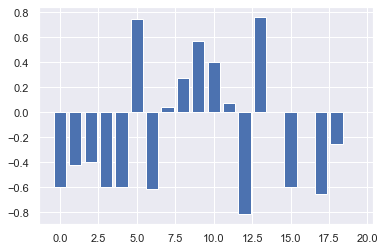

In [723]:
# Seems that inevitably, some of these sentences are going to get incorrect sentiment scores.
# I wonder what the mean compound score for the sentences will look like.

test_score_lst = []
for sent in df_sent_dom_topics['original_text'][:20]:
    test_score_lst.append(anakin.polarity_scores(sent)['compound'])

plt.bar(range(0,len(test_score_lst)),test_score_lst)

In [724]:
#How does this compare to the original full review?

full_test_sent = final_data['original_text'][0]
print(full_test_sent)
print(anakin.polarity_scores(full_test_sent))

Well for me game still tons of work. i like it but just cant recommend.
1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.
2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings that supply you with certain kind 

In [725]:
# Compound score is overwhelmingly negative for the review as a whole.
# The review is both scathing and sarcastic, so I was not expecting a very clear negative.
# I believe the sentiment analyzer should be derive reasonably accurate sentiment scores, but it may not necessarily apply to short sentences.

#time to finish this analysis

#get compound sentiment score for all sentences
df_sent_dom_topics['compound_sentiment'] = df_sent_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [726]:
df_sent_dom_topics.head(10)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994
1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215
2,Tactical Gameplay,0.5900,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019
3,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994
4,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994
5,Strategic Gameplay,0.7153,"[rule, paradox]","[rather, than, improve, it, and, make, it, pla...",2,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...,0.7506
6,Strategic Gameplay,0.7877,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"faction, army, diplomacy, vassal, war, player,...",they rather make ai cheat and brake rules like...,-0.6115
7,Strategic Gameplay,0.4524,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...,0.0397
8,Strategic Gameplay,0.6122,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...,0.2732
9,Strategic Gameplay,0.7912,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...,0.5719


(array([ 273.,  544.,  775.,  792.,  573., 2245.,  625., 1204., 1176.,
        1574.,  975.]),
 array([-0.9934    , -0.81363636, -0.63387273, -0.45410909, -0.27434545,
        -0.09458182,  0.08518182,  0.26494545,  0.44470909,  0.62447273,
         0.80423636,  0.984     ]),
 <a list of 11 Patch objects>)

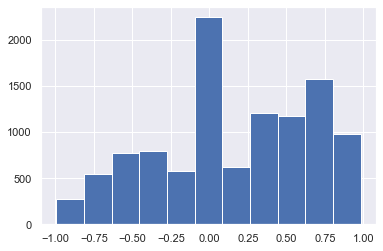

In [727]:
# Explore distribution of sentiment scores

sentiment_lst = df_sent_dom_topics['compound_sentiment']

plt.hist(sentiment_lst,bins=11) #give odd number so 0.00 has its own bin

In [728]:
# Most sentiment is positive, which is consistent with the rating on Steam

# Looking for a good cutoff point for sentiment, I started by setting the cutoffs to X > 0, X ==0, and X < 0 to reduce any chances of bias when setting the cutoffs

pos_lst = [x for x in sentiment_lst if x > 0] #find reasonable cutoffs for positive/negative
neutral_lst = [x for x in sentiment_lst if x == 0] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < 0] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst)) #Find out how many reviews would be classified under pos, neutral, or neg and what percentage of the total dataset are they?

0.5598735589438453
0.14168835998512458
0.29843808107103015


In [729]:
# Seems like this will reduce Neutrals greatly, but it doesn't seem logical. Nobody really has a sentiment of 0.00000 on anything 
# That and P(X=0) on a continuous distribution is 0!

# From a logical standpoint, 0.1 sentiment in either direction should indicate a relatively clear leaning towards either positive or negative

pos_lst = [x for x in sentiment_lst if x > 0.1] #positive scores
neutral_lst = [x for x in sentiment_lst if x >=-0.1 and x <=0.1] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < -0.1] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst))

0.514782447006322
0.2104871699516549
0.2747303830420231


In [730]:
pos_lst = [x for x in sentiment_lst if x > 0.2] #positive scores
neutral_lst = [x for x in sentiment_lst if x >=-0.2 and x <=0.2] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < -0.2] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst))

0.4838229825213834
0.2683153588694682
0.24786165860914838


In [731]:
# It seems that setting the cutoffs to 0.1 is a good option. Widening the boundary to 0.2 would result in a much higher Neutral count.

# Setting boundaries to 0.1 will slightly increase the number of reviews classified as neutral, but the tradeoff is worth it.

perc_dict = {}

for topic in list(topic_dict.values()):
    
    topic_mask = df_sent_dom_topics['dominant_topic']==topic
    topic_df = df_sent_dom_topics[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict

{'Content & Authenticity': [0.528, 0.205, 0.267],
 'Characters': [0.467, 0.247, 0.287],
 'Strategic Gameplay': [0.476, 0.246, 0.278],
 'Tactical Gameplay': [0.526, 0.195, 0.279],
 'UX/UI, Performance, Stability': [0.504, 0.201, 0.295]}

# Method 2
2. By review
    - Score sentiment on the whole review
    - Aggregate by topic then by sentiment type 
        - Positive, neutral, negative </br></br>

In [732]:
#Let's try this at the document level rather than sentence level, just to see what happens

final_data['compound_sentiment'] = final_data['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [733]:
#sentiment analysis by review (NOT by sentence)

perc_dict2 = {}

for topic in list(topic_dict.values()):
    
    topic_mask = final_data['dominant_topic']==topic
    topic_df = final_data[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict2[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict2

{'Content & Authenticity': [0.764, 0.104, 0.131],
 'Characters': [0.534, 0.188, 0.277],
 'Strategic Gameplay': [0.637, 0.038, 0.325],
 'Tactical Gameplay': [0.7, 0.042, 0.258],
 'UX/UI, Performance, Stability': [0.673, 0.084, 0.244]}

In [734]:
print("By sentence\n",perc_dict)
print("\nBy review\n",perc_dict2)

By sentence
 {'Content & Authenticity': [0.528, 0.205, 0.267], 'Characters': [0.467, 0.247, 0.287], 'Strategic Gameplay': [0.476, 0.246, 0.278], 'Tactical Gameplay': [0.526, 0.195, 0.279], 'UX/UI, Performance, Stability': [0.504, 0.201, 0.295]}

By review
 {'Content & Authenticity': [0.764, 0.104, 0.131], 'Characters': [0.534, 0.188, 0.277], 'Strategic Gameplay': [0.637, 0.038, 0.325], 'Tactical Gameplay': [0.7, 0.042, 0.258], 'UX/UI, Performance, Stability': [0.673, 0.084, 0.244]}


# Method 3

3. By sentence topics within each review
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Group sentences and their sentiment scores by topic, for each review
    - Aggregate scores for all reviews by topic then by sentiment type </br></br>

### Preprocessing

In [735]:
final_data.head(2)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,compound_sentiment
0,Tactical Gameplay,Well for me game still tons of work. i like it...,0.4890,"['ton', 'diplomacy', 'joke', 'military_access'...",84,"['turn', 'rule', 'stability', 'siege', 'peace'...",57,"unit, battle, faction, army, general, characte...",-0.9892
1,Characters,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,0.7433,"['lu_bu', 'lu_bu']",2,['lu_bu'],1,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",0.0000


In [736]:
big_sent_lst2 =[] #For storing ALL sentences in the dataset. Another list will help label which reviews they came from

review_index_lst = [] #for storing all index numbers for each sentence so we can identify which reviews they belong to and thus group scores by topics and reviews

sent_df2 = pd.DataFrame() #For visualisation of sentence transformations and saving of data

review_count = 0
for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst2.extend(sent_tokens)
    
    review_count+=1
    review_num_lst = [str(review_count)] * len(sent_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
    review_index_lst.extend(review_num_lst)

sent_df2['sentences'] = big_sent_lst2
sent_df2['review_number'] = review_index_lst
sent_df2.head()

,sentences,review_number
0,well for me game still tons of work,1
1,like it but just cant recommend,1
2,1,1
3,diplomacy,1
4,it is joke,1


In [737]:
sent_df2['token_sentences'] = [x.split() for x in big_sent_lst2]

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

sent_df2['sents_unstopped'] = sent_df2['token_sentences'].map(lambda x: remove_stopwords(x))
sent_df2['3gram_sentences'] = make_trigrams(sent_df2['sents_unstopped'])
sent_df2['3gram_sentences'] = sent_df2['3gram_sentences'].map(lambda x: spacy_lemma(x))

en_stopwords.extend(['one','two','three','thing','bit','total_war','time','10_10','love','fun','play','hour']) #after making bigrams, removing numbers should reduce noise

sent_df2['3gram_sentences_clean'] = sent_df2['3gram_sentences'].map(lambda x: remove_stopwords(x))
sent_df2['num_tokens'] = sent_df2['3gram_sentences_clean'].map(lambda x: len(x))

In [738]:
len(sent_df2)

16739

In [739]:
sent_df2.head(10)

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,well for me game still tons of work,1,"[well, for, me, game, still, tons, of, work]","[tons, work]","[ton, ]",[ton],1
1,like it but just cant recommend,1,"[like, it, but, just, cant, recommend]",[recommend],[],[],0
2,1,1,[1],[one],[],[],0
3,diplomacy,1,[diplomacy],[diplomacy],[diplomacy],[diplomacy],1
4,it is joke,1,"[it, is, joke]",[joke],[joke],[joke],1
5,nothing works,1,"[nothing, works]",[works],[work],[work],1
6,you have trade and military access with cao ca...,1,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
7,you are too small,1,"[you, are, too, small]",[small],[],[],0
8,well you will get war declaration each turn in...,1,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
9,its ok if you are at war with more factions th...,1,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3


In [740]:
ultimate_sent_df = sent_df2[sent_df2['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(sent_df2)-len(ultimate_sent_df))/len(sent_df2)
print(dropped_rows)
print(len(ultimate_sent_df))

0.3574287591851365
10756


In [741]:
ultimate_sent_df.head(10)

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,you have trade and military access with cao ca...,1,"[you, have, trade, and, military, access, with...","[trade, military, access, cao, cao, war, decla...","[trade, military_access, cao_cao, war, declara...","[trade, military_access, cao_cao, war, declara...",6
1,well you will get war declaration each turn in...,1,"[well, you, will, get, war, declaration, each,...","[war, declaration, turn]","[war, declaration, turn]","[war, declaration, turn]",3
2,its ok if you are at war with more factions th...,1,"[its, ok, if, you, are, at, war, with, more, f...","[ok, war, factions, armies]","[, war, faction, army]","[war, faction, army]",3
3,oh and if you are too big guess what still war...,1,"[oh, and, if, you, are, too, big, guess, what,...","[oh, big, guess, war, turn]","[, , guess, war, turn]","[guess, war, turn]",3
4,mean did they even test this diplomacy war dec...,1,"[mean, did, they, even, test, this, diplomacy,...","[mean, test, diplomacy, war, declaration, run]","[, test, diplomacy, war, declaration, ]","[test, diplomacy, war, declaration]",4
5,rather than improve it and make it play by the...,1,"[rather, than, improve, it, and, make, it, pla...","[improve, play, rules, paradox]","[, play, rule, paradox]","[rule, paradox]",2
6,they rather make ai cheat and brake rules like...,1,"[they, rather, make, ai, cheat, and, brake, ru...","[ai, cheat, brake, rules, having, shadow, inco...","[, , brake, rule, , shadow, income, , punishme...","[brake, rule, shadow, income, punishment, pact]",6
7,like in eu4 where your stability drops if you ...,1,"[like, in, eu4, where, your, stability, drops,...","[eu4, stability, drops, declare, war, reason, ...","[, stability, , declare_war, reason, attack, e...","[stability, declare_war, reason, attack, enemy...",6
8,you have about chains of troop buildings that ...,1,"[you, have, about, chains, of, troop, building...","[chains, troop, buildings, supply, certain, ki...","[chain, troop, building, , , , troop]","[chain, troop, building, troop]",4
9,wanna have artillery ok just build artillery s...,1,"[wanna, have, artillery, ok, just, build, arti...","[wanna, artillery, ok, build, artillery, school]","[, artillery, , , artillery, school]","[artillery, artillery, school]",3


In [742]:
ultimate_sent_df.select_dtypes(include='O').describe()

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean
count,10756,10756,10756,10756,10756,10756
unique,10731,2976,10730,10693,10665,10445
top,best total war since shogun 2,2296,"[best, total, war, since, shogun, 2]","[best, total, war, shogun, two]","[best_total_war, shogun_two]","[best_total_war, series]"
freq,5,56,5,12,12,13


In [743]:
ultimate_sent_df.isnull().sum()

sentences                0
review_number            0
token_sentences          0
sents_unstopped          0
3gram_sentences          0
3gram_sentences_clean    0
num_tokens               0
dtype: int64

In [744]:
ultimate_sent_df.describe()

,num_tokens
count,10756.000000
mean,4.165396
std,2.891575
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,40.000000


In [745]:
# run model on newly-made sentence dataframe

documents2 = list(ultimate_sent_df['3gram_sentences_clean'])

dictionary2 = gensim.corpora.Dictionary(documents2)

dictionary2.filter_extremes(no_below = 5,no_above=0.5)  

corpus2 = [dictionary2.doc2bow(text) for text in documents2] #dictionary previously defined above

In [746]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

def format_topics_sentences(df,ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(df[['sentences','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return sent_topics_df

In [747]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ultimate_sent_df,ldamodel=lda_model, corpus=corpus2, documents=documents2)

In [748]:
# Format dataframe
df_sent_dom_topics = df_topic_sents_keywords.reset_index()

df_sent_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

df_sent_dom_topics['num_tokens']=ultimate_sent_df['num_tokens']
df_sent_dom_topics['review_number']=ultimate_sent_df['review_number'].map(lambda x: int(x))

df_sent_dom_topics = df_sent_dom_topics[['review_number','dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
df_sent_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...
2,1,Tactical Gameplay,0.5902,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...
5,1,Strategic Gameplay,0.7153,"[rule, paradox]","[rather, than, improve, it, and, make, it, pla...",2,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...
6,1,Strategic Gameplay,0.7877,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"faction, army, diplomacy, vassal, war, player,...",they rather make ai cheat and brake rules like...
7,1,Strategic Gameplay,0.4524,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...
8,1,Strategic Gameplay,0.6122,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...
9,1,Strategic Gameplay,0.7912,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...


In [749]:
max((df_sent_dom_topics['review_number'].unique())) #check that highest value of unique review numbers == len of review count

3660

In [750]:
df_sent_dom_topics['compound_sentiment'] = df_sent_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])
df_sent_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215
2,1,Tactical Gameplay,0.5902,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994
5,1,Strategic Gameplay,0.7153,"[rule, paradox]","[rather, than, improve, it, and, make, it, pla...",2,"faction, army, diplomacy, vassal, war, player,...",rather than improve it and make it play by the...,0.7506
6,1,Strategic Gameplay,0.7877,"[brake, rule, shadow, income, punishment, pact]","[they, rather, make, ai, cheat, and, brake, ru...",6,"faction, army, diplomacy, vassal, war, player,...",they rather make ai cheat and brake rules like...,-0.6115
7,1,Strategic Gameplay,0.4524,"[stability, declare_war, reason, attack, enemy...","[like, in, eu4, where, your, stability, drops,...",6,"faction, army, diplomacy, vassal, war, player,...",like in eu4 where your stability drops if you ...,0.0397
8,1,Strategic Gameplay,0.6122,"[chain, troop, building, troop]","[you, have, about, chains, of, troop, building...",4,"faction, army, diplomacy, vassal, war, player,...",you have about chains of troop buildings that ...,0.2732
9,1,Strategic Gameplay,0.7912,"[artillery, artillery, school]","[wanna, have, artillery, ok, just, build, arti...",3,"faction, army, diplomacy, vassal, war, player,...",wanna have artillery ok just build artillery s...,0.5719


In [751]:
df_sent_dom_topics.to_csv('./dataframes/final_agg_sent_topics.csv')

In [752]:
#try a few ways of aggregating compound sentiment by topic for 1 review

toy_sent_data = df_sent_dom_topics[df_sent_dom_topics['review_number']==1]
toy_sent_data.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215
2,1,Tactical Gameplay,0.5902,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994


In [753]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].sum()

dominant_topic
Strategic Gameplay   -0.1640
Tactical Gameplay    -2.5077
Name: compound_sentiment, dtype: float64

In [754]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].mean()

dominant_topic
Strategic Gameplay   -0.016400
Tactical Gameplay    -0.278633
Name: compound_sentiment, dtype: float64

In [755]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].median()

dominant_topic
Strategic Gameplay    0.05845
Tactical Gameplay    -0.42150
Name: compound_sentiment, dtype: float64

In [756]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].count()

dominant_topic
Strategic Gameplay    10
Tactical Gameplay      9
Name: compound_sentiment, dtype: int64

# Deciding on Aggregation

The mean is the least preferred option because it includes outliers, which can skew the data.

Using sum is not much different from the mean, and in fact creates another problem because it doesn't work on the same scale as VADER (floating points from -1.0 to 1.0).

Median should work just fine. It should show a score that reflects the general direction of the sentiment, since it is the middle point in all of the data.

Text(0, 0.5, 'Number of sentences')

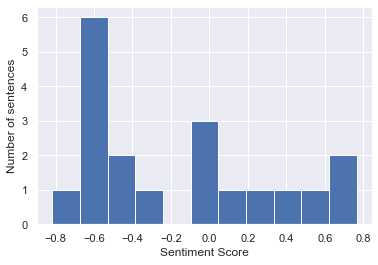

In [757]:
#Visualise distribution of sentiment scores
plt.hist(toy_sent_data['compound_sentiment'],bins=11) #use odd numbers so the neutral ones have their own bin in the centre
plt.xlabel('Sentiment Score')
plt.ylabel('Number of sentences')

In [758]:
print("mean:",toy_sent_data['compound_sentiment'].mean())
print("median:",toy_sent_data['compound_sentiment'].median())

mean: -0.14061578947368425
median: -0.25


In [759]:
# The median is more reflective of the general sentiment of the review's sentences, but the score is not severely negative like the actual review.
# Maybe this problem has a simple solution.
# We convert everything to integers instead of floats

def sent_score_int(score_lst):
    int_scores = [(-1 if x <-0.1 else (0 if -0.1 <= x <= 0.1 else 1)) for x in score_lst]
    return int_scores

toy_sent_data['int_scores'] = sent_score_int(toy_sent_data['compound_sentiment'])
toy_sent_data.head()

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994,-1
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215,-1
2,1,Tactical Gameplay,0.5902,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019,-1
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994,-1
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994,-1


In [760]:
# Now, any score that is conclusively negative (x<-0.1) is assigned the value of -1; 0 for neutral (-0.1 < x < 0.1), 1 for positive (x > 0.1)
# The exact score is not important for this model. All we need is whether a review is positive, netural, or negative.

topic_df = toy_sent_data[toy_sent_data['dominant_topic'] == topic_dict['3']]

review_dict= {}

score_lst = list(topic_df['int_scores'])

rev_topic_pos = score_lst.count(1)/len(score_lst)
rev_topic_neutral = score_lst.count(0)/len(score_lst)
rev_topic_neg = score_lst.count(-1)/len(score_lst)

print("Positive:",rev_topic_pos)
print("Neutral:",rev_topic_neutral)
print("Negative:",rev_topic_neg)

review_scores = [rev_topic_pos, rev_topic_neutral, rev_topic_neg]

mx = max(review_scores)

#assign sentiment rating based on the dominant sentiment for the current topic
if mx == review_scores[0]:
    sentiment = 1

elif mx == review_scores[1]:
    sentiment = 0

else:
    sentiment = -1

review_dict[topic_dict['3']]=sentiment
print(review_dict)

Positive: 0.1111111111111111
Neutral: 0.2222222222222222
Negative: 0.6666666666666666
{'Tactical Gameplay': -1}


In [761]:
t_dict = {'0':[],
          '1':[],
          '2':[],
          '3':[],
          '4':[]
         }

t_dict['0'].append(1)
t_dict['0'].append(1)
t_dict['0'].append(-1)
t_dict

{'0': [1, 1, -1], '1': [], '2': [], '3': [], '4': []}

In [762]:
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }
score_dict

{'Content & Authenticity': [],
 'Characters': [],
 'Strategic Gameplay': [],
 'Tactical Gameplay': [],
 'UX/UI, Performance, Stability': []}

In [763]:
#Transform sentiment scores for the larger dataset
df_sent_dom_topics['int_scores'] = sent_score_int(df_sent_dom_topics['compound_sentiment'])
df_sent_dom_topics.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,1,Tactical Gameplay,0.8757,"[trade, military_access, cao_cao, war, declara...","[you, have, trade, and, military, access, with...",6,"unit, battle, faction, army, general, characte...",you have trade and military access with cao ca...,-0.5994,-1
1,1,Tactical Gameplay,0.7831,"[war, declaration, turn]","[well, you, will, get, war, declaration, each,...",3,"unit, battle, faction, army, general, characte...",well you will get war declaration each turn in...,-0.4215,-1
2,1,Tactical Gameplay,0.5902,"[war, faction, army]","[its, ok, if, you, are, at, war, with, more, f...",3,"unit, battle, faction, army, general, characte...",its ok if you are at war with more factions th...,-0.4019,-1
3,1,Tactical Gameplay,0.7746,"[guess, war, turn]","[oh, and, if, you, are, too, big, guess, what,...",3,"unit, battle, faction, army, general, characte...",oh and if you are too big guess what still war...,-0.5994,-1
4,1,Tactical Gameplay,0.8273,"[test, diplomacy, war, declaration]","[mean, did, they, even, test, this, diplomacy,...",4,"unit, battle, faction, army, general, characte...",mean did they even test this diplomacy war dec...,-0.5994,-1


In [764]:
# Now we do the above for all topics in the whole review... which we will later transplant into a higher-level loop that goes through all reviews one by one in this manner

# define function to find mode

    # fixing a mistake I made earlier
    # the method I used above will return the 1st mode if there is more than 1 mode

def mode_function2(lst):
    counter = Counter(lst)
    _,val = counter.most_common(1)[0]
    return [x for x,y in counter.items() if y == val]

#init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[],
              topic_dict['4']:[]
             }

review_numbers = list(df_sent_dom_topics['review_number'].unique())[:2] #for now we will just take 2 reviews to test this loop

for i in review_numbers: 

    review_mask = df_sent_dom_topics['review_number'] == i
    review_df = df_sent_dom_topics[review_mask]

    for key in topic_dict:

        topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

        if len(topic_df) == 0:
            pass

        else:

            score_lst = list(topic_df['int_scores'])
            mode_lst = mode_function2(score_lst)
            

            if len(mode_lst) ==1:     #ideally, we only have one mode in the list
                
                sentiment = mode_lst[0]

            elif len(mode_lst) >1:   #for dealing with multiple modes
                
                sentiment = 0 #since sentiment is mixed, assign neutral sentiment value

            score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

print(score_dict)

{'Content & Authenticity': [1], 'Characters': [], 'Strategic Gameplay': [0, 0], 'Tactical Gameplay': [-1, 0], 'UX/UI, Performance, Stability': []}


In [765]:
#verify results(1)
review_mask = df_sent_dom_topics['review_number'] == review_numbers[0]
review_df = df_sent_dom_topics[review_mask]
review_df.groupby('dominant_topic')['int_scores'].apply(lambda x: x.mode()) #used only here for quick verification -- 

dominant_topic       
Strategic Gameplay  0   -1
                    1    1
Tactical Gameplay   0   -1
Name: int_scores, dtype: int64

In [766]:
#verify results(2)
review_mask = df_sent_dom_topics['review_number'] == review_numbers[1]
review_df = df_sent_dom_topics[review_mask]
review_df.groupby('dominant_topic')['int_scores'].apply(lambda x: x.mode())

dominant_topic           
Content & Authenticity  0    1
Strategic Gameplay      0    0
Tactical Gameplay       0   -1
                        1    0
Name: int_scores, dtype: int64

In [841]:
#The test results match: 1 pos for Series Authenticity, 1 pos and 1 neutral for Characters, 1 pos for Strategic Gameplay, 2 neg for Tactical Gameplay, no results for Performance & Stability

#now running for all reviews

review_numbers = list(df_sent_dom_topics['review_number'].unique()) #iterates through ALL reviews in the dataset

def score_reviews(review_numbers,df):

    #init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
    score_dict = {topic_dict['0']:[],
                  topic_dict['1']:[],
                  topic_dict['2']:[],
                  topic_dict['3']:[],
                  topic_dict['4']:[]
                 }

    final_score_dict = {}
    
    for i in review_numbers: 

        review_mask = df['review_number'] == i
        review_df = df[review_mask]

        for key in topic_dict:

            topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

            if len(topic_df) == 0:
                pass

            else:

                score_lst = list(topic_df['int_scores'])

                mode_lst = mode_function2(score_lst) 

                if len(mode_lst) ==1:     #ideally, we only have one mode in the list

                    sentiment = mode_lst[0]

                elif len(mode_lst) >1:   #for dealing with multiple modes

                    sentiment = 0 #Sentiment is mixed when there are multiple modes, thus assign neutral sentiment value


                score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

    for key in score_dict:
        full_score_lst = score_dict[key]

        full_topic_pos = full_score_lst.count(1)/len(full_score_lst)
        full_topic_neutral = full_score_lst.count(0)/len(full_score_lst)
        full_topic_neg = full_score_lst.count(-1)/len(full_score_lst)

        full_scores = [round(full_topic_pos,3),round(full_topic_neutral,3),round(full_topic_neg,3)]

        final_score_dict[key] = full_scores

    return final_score_dict

In [850]:
test_topic_lst = []

test_review_num_lst = range(25)

test_int_scores = [-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,0,1,1,0,0,1,0,0,1,1,0,1,1]

for key in topic_dict.values():
    test_topic_lst_a = [key] * 5
    test_topic_lst.extend(test_topic_lst_a)

test_dict={'dominant_topic':test_topic_lst,
           'review_number':test_review_num_lst,
           'int_scores':test_int_scores
          }

uni_rn = list(sorted(set(test_review_num_lst)))

test_frame = pd.DataFrame(test_dict)
test_frame

,dominant_topic,review_number,int_scores
0,Content & Authenticity,0,-1
1,Content & Authenticity,1,-1
2,Content & Authenticity,2,-1
3,Content & Authenticity,3,-1
4,Content & Authenticity,4,-1
5,Characters,5,-1
6,Characters,6,-1
7,Characters,7,-1
8,Characters,8,-1
9,Characters,9,0


In [851]:
score_reviews(uni_rn,test_frame)

{'Content & Authenticity': [0.0, 0.0, 1.0],
 'Characters': [0.0, 0.2, 0.8],
 'Strategic Gameplay': [0.8, 0.2, 0.0],
 'Tactical Gameplay': [0.2, 0.8, 0.0],
 'UX/UI, Performance, Stability': [0.8, 0.2, 0.0]}

In [852]:
final_score_dict = score_reviews(review_numbers,df_sent_dom_topics)

In [853]:
# Summarise data in a dataframe for easier viewing

overall_score_df = pd.DataFrame(final_score_dict).T
#overall_score_df.index = ['Pos','Neutral','Neg']
overall_score_df.columns = ['Pos','Neutral','Neg']
overall_score_df

,Pos,Neutral,Neg
Content & Authenticity,0.530,0.285,0.185
Characters,0.460,0.323,0.217
Strategic Gameplay,0.470,0.317,0.214
Tactical Gameplay,0.530,0.260,0.210
"UX/UI, Performance, Stability",0.482,0.263,0.255


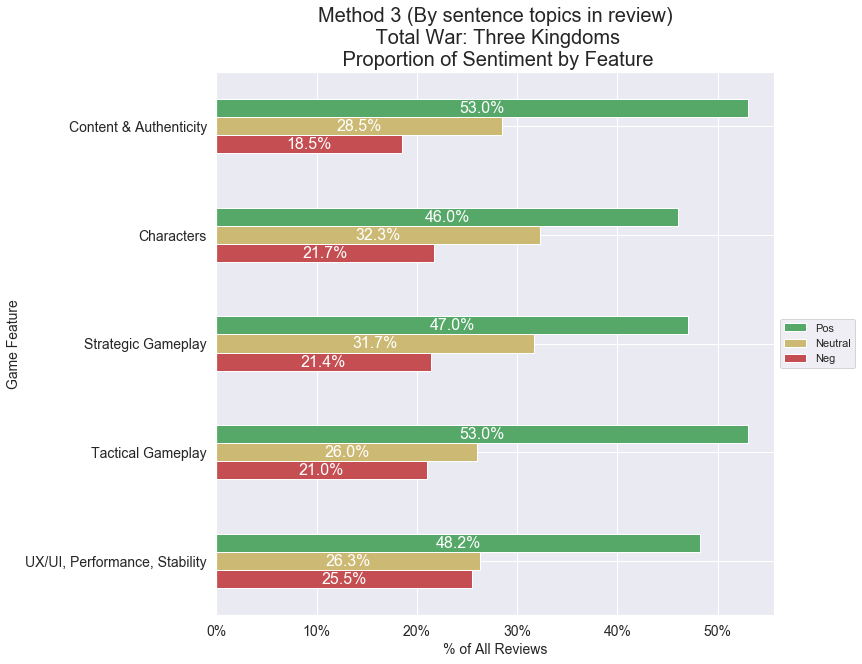

In [770]:
#plot visualisation for the results of the 3rd attempt at aggregation
ax = overall_score_df.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Method 3 (By sentence topics in review)\n Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

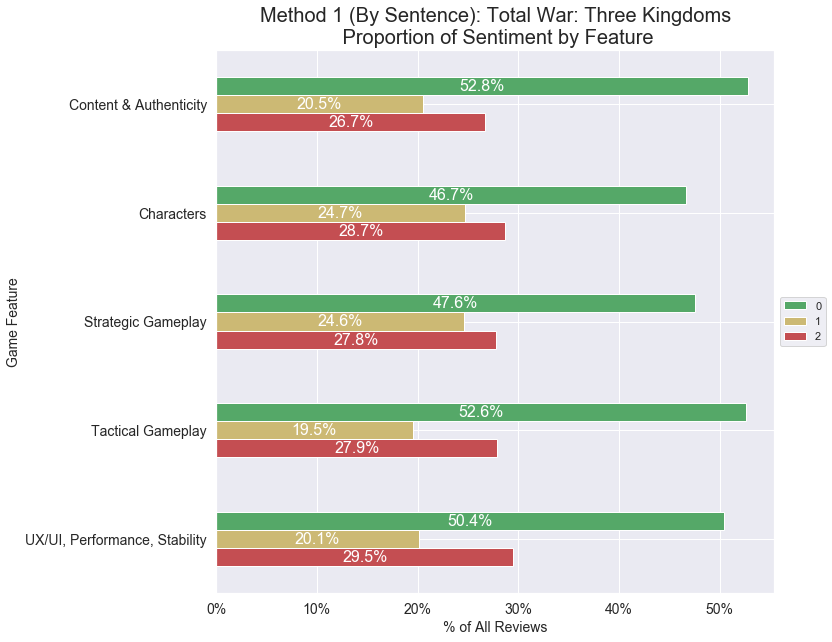

In [771]:
#comparison to Method 1 (by sentence)

ax = pd.DataFrame(perc_dict).T.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Method 1 (By Sentence): Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

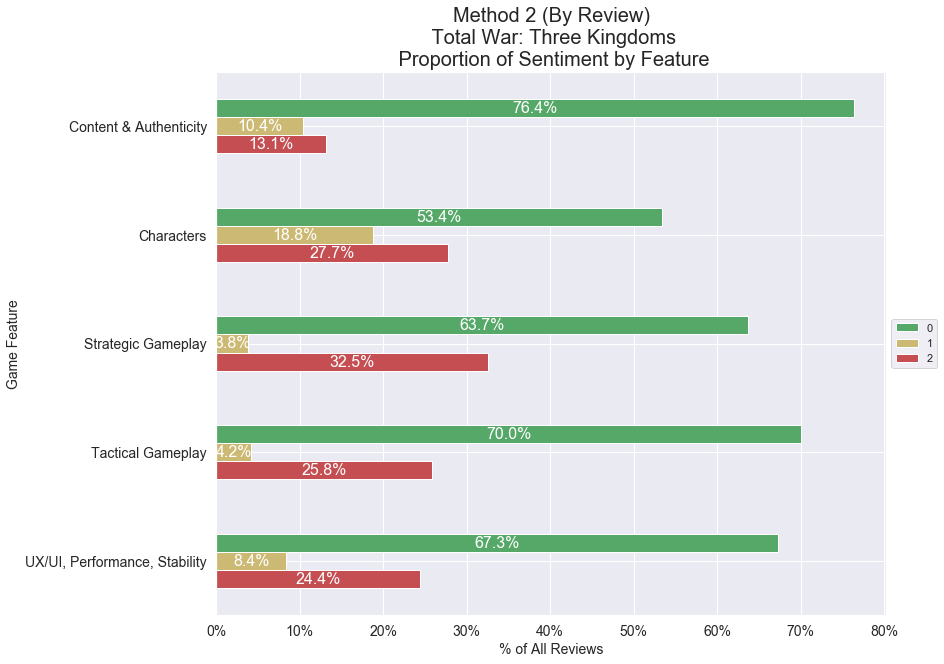

In [772]:
#comparison to other methods -- percentage_dict2, from the by-review approach 

ax = pd.DataFrame(perc_dict2).T.plot(kind='barh',figsize=(12,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Method 2 (By Review)\n Total War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

# Review of Method 3

#### Comparison to previous methods:
- Seems to output results very similar to Method 1.
- However, getting Method 1's results was more akin to random chance.

#### Method 3 differences:
- More rigorous.
- More closely follows the way a human would identify topics and score sentiments for each review.

#### Findings:
- Assigning neutral sentiment values to mixed reviews made the results to less in favour of Positive sentiment, more in favour of Neutral, and had little effect on Negative sentiment.
- This is a logical process; multiple dominating sentiments should logically indicate mixed sentiment

Method 3 has a more rigorous mathematical and logical process backing it, so I believe in it more than Methods 1 and 2.

But something is still missing... short sentences (as tokenised by SpaCy) are still a major issue. SpaCy tokenisation is less coherent (as tested above).

Perhaps we can go by paragraphs?

# Method 4: <span style = "color:blue">The Chosen One</span>

4. By "paragraphs" within each review   
    - Break reviews into "paragraphs" (Syntok; explained below)
    - Get dominant topic for each "paragraph"
    - Score sentiment for each "paragraph"
    - Get dominant topic for each "paragraph"
    - Group "paragraphs" and sentiment scores by topic, for each review 
    - Aggregate scores for all reviews by topic then by sentiment type

In [773]:
#Found a better sentence tokeniser
#SpaCy sentence tokeniser breaks sentences at intervals that tend to make sentences less coherent
#Syntok seems to tokenise coherent sentences
#https://github.com/fnl/syntok/blob/master/README.rst


#test syntok segmenter on one review
reviews = final_data['original_text'][:1]

dl = []

for i in range(len(reviews)):
    document = reviews[i]

    for paragraph in segmenter.process(document):
        pl = []
        sent_ct = 0
        for sentence in paragraph:
            sent_ct+=1
            sl = []
            for token in sentence:
                # roughly reproduce the input,
                # except for hyphenated word-breaks
                # and replacing "n't" contractions with "not",
                # separating tokens by single spaces
                sl.append(token.value)
            sl = [' '.join(w for w in sl)]

            print(str(sent_ct)+':',sl)  # print one sentence per line
        
            pl.append(sl)
        
        print("\n")  # separate paragraphs with newlines
        
        dl.append(pl)
        
    #print(dl)    #print this to see a list of lists of lists. Beware! Can look messy!

1: ['Well for me game still tons of work . i like it but just cant recommend .']
2: ['1 . Diplomacy .']
3: ['It is joke .']
4: ['Nothing works .']
5: ['You have trade and military access with CAO CAO ?']
6: ['War declaration next turn .']
7: ['You are too small ? well you will get war declaration each turn .']
8: ['In this game its ok if you are at war with more factions than you have armies .']
9: ['Oh and if you are too big ? guess what ? still war each turn . i mean did they even test this diplomacy ?']
10: ['3 war declaration in t run ? for nothing ? i am total war veteran and i can see what they have done with AI .']
11: ['Rather than improve it and make it play by the rules like paradox have done .']
12: ['They rather make AI cheat and brake rules like having , , shadow income " .']
13: ['Or have some sort of punishment for breaking pacts .']
14: ['Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you .']
15: ['2 

In [774]:
# SpaCy returned 41 sentences from the same review, whereas Syntok returned 27 coherent sentences. Seems promising.

# The following code includes clauses related to expandContractions which can be safely removed with no issue. 

# They are for demonstrating the paragraphing effect of expandContractions(), a complete accident!

def syntokenize(reviews,expcon=True, expconbreak=False):
    
    orig_sents = []

    review_tokens = []
    
    full_review_tokens = []
    
    review_index_lst = [] #for identifying review number

    for i in range(len(reviews)):
        document = reviews[i]
        orig_doc = document

        document = parse(document)
        
        if expcon==True:    #Assign False to see that Syntok tokenises differently without expandContractions()
            doc_prior = document
            
            document = expandContractions(document) #put this in an if-else to demonstrate that expandContractions is causing sentences to be made into paragraphs
            
            if expconbreak==True:
                #print("Original\n\n",orig_doc,"\n\n")
                print("Prior to expandContractions()\n\n",doc_prior,"\n\n")
                print("After expandContractions()\n\n",document)
                break
            
        else:
            pass

        document = [word for word in document.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')]
        document = ' '.join(word for word in document)

        for doc in segmenter.process(document):
            review_tokens = []
            
            for sentence in doc:
                sl = []
                
                for token in sentence:
                    
                    sl.append(token.value)
                
                sl = re.sub(r'\s([?.!"](?:\s|$))', r'\1', ' '.join(word for word in sl)) #remove whitespace only before punctuation at end of sentence

                review_tokens.append(sl)
                
            review_num_lst = [str(i)] * len(review_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
            review_index_lst.extend(review_num_lst)
            
        full_review_tokens.extend(review_tokens) #join new sent as str to end of this list
        
    return full_review_tokens, review_index_lst

In [775]:
syntokenize(final_data['original_text'][:2])

(['well for me game still tons of work. like it but just cant recommend.',
  '1. diplomacy it is joke. nothing works. you have trade and military access with cao cao war declaration next turn. you are too small well you will get war declaration each turn in this game its ok if you are at war with more factions than you have armies. oh and if you are too big guess what still war each turn. mean did they even test this diplomacy war declaration in run for nothing? i am total war veteran and can see what they have done with ai. rather than improve it and make it play by the rules like paradox have done. they rather make ai cheat and brake rules like having , , shadow income" . or have some sort of punishment for breaking pacts. like in eu4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.',
  '2. troops. in twh ( also in rome ) all is simple. you have about chains of troop buildings that supply you with certain kind of troops. wa

In [776]:
# Happy accident! The text is being returned as paragraphs. I was looking for a tool that could do this, but couldn't find one.

# Originally it only returned single sentences as separated by '\n'. It also doesn't work well on Steam reviews. It works better on long documents.

# At this point I did some manual inspection. It turned out that expandContractions() is the one causing the sentences to become paragraphs.

# I have disabled expandContractions() to demonstrate the effect below.

syntokenize(final_data['original_text'][:1],expcon=False)

(['Well for me game still tons of work. like it but just cant recommend.',
  '1. Diplomacy It is joke.',
  'Nothing works.',
  'You have trade and military access with CAO CAO War declaration next turn.',
  'You are too small well you will get war declaration each turn In this game its ok if you are at war with more factions than you have armies.',
  'Oh and if you are too big guess what still war each turn. mean did they even test this diplomacy war declaration in run for nothing? i am total war veteran and can see what they have done with AI.',
  'Rather than improve it and make it play by the rules like paradox have done.',
  'They rather make AI cheat and brake rules like having , , shadow income" .',
  'Or have some sort of punishment for breaking pacts.',
  'Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.',
  '2. Troops.',
  'In TWH ( also in Rome ) all is simple.',
  'You have about chains of troop buildin

In [777]:
# Break out of the loop during expandContractions() just after the first run, just to see if there are significant formatting changes prior to other cleaning steps

# testing on more than 1 review
syntokenize(final_data['original_text'][:2],expcon=True,expconbreak=True)

Prior to expandContractions()

 Well for me game still tons of work. i like it but just cant recommend.
1. Diplomacy . It is joke. Nothing works. You have trade and military access with CAO CAO ? War declaration next turn. You are too small ? well you will get war declaration each turn . In this game its ok if you are at war with more factions than you have armies.  Oh and if you are too big ? guess what ? still war each turn. i mean did they even test this diplomacy ? 3 war declaration in t run ? for nothing ?i am total war  veteran and i can see what they have done with AI. Rather than improve it and make it play by the rules like paradox have done. They rather make AI cheat and brake rules like having ,,shadow income".  Or have some sort of punishment for breaking pacts. Like in EU4 where your stability drops if you declare war without reason or attack enemy that just signed peace with you.
2. Troops. In TWH( also in Rome) all is simple. You have about 3 chains of troop buildings th

([], [])

In [778]:
#Further investigation may be warranted, but in any case it is a positive unintended effect. It does what I need it to do.
#It is also generally a better package for sentence tokenisation than SpaCy.

syntok_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

reviews = final_data['original_text'].reset_index(drop=True) #reset_index() needed because this returns a series with old index numbers

syntok_sent_lst, review_index_lst = syntokenize(reviews)

syntok_df['sentences'] = syntok_sent_lst
syntok_df['review_number'] = review_index_lst

print(len(syntok_df))
print(abs(len(syntok_df)-len(final_data)))
print(abs(len(syntok_df)-len(final_data))/len(final_data))
syntok_df.head()

4303
642
0.17536192297186562


,sentences,review_number
0,well for me game still tons of work. like it b...,0
1,1. diplomacy it is joke. nothing works. you ha...,0
2,2. troops. in twh ( also in rome ) all is simp...,0
3,3. city building. tons of buildings that you w...,0
4,pursued lu bu. now am lu bu.,1


In [779]:
# We gained 623 (~20%) more rows (as compared to original number of rows in of dataset) as new lines.

# Considering most reviews most reviews are very short (about 1 paragraph), this result is quite good.

# This would be less biased than going purely by the whole review. Each "paragraph" is tokenised as a very long sentence by Syntok.

# The sentences are more likely to be accurately classified!

syntok_df['clean_sentences'] = remove_punc(syntok_sent_lst)
syntok_df['token_sentences'] = [x.split() for x in syntok_df['clean_sentences']]

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

syntok_df['sents_unstopped'] = syntok_df['token_sentences'].map(lambda x: remove_stopwords(x))
syntok_df['3gram_sentences'] = make_trigrams(syntok_df['sents_unstopped'])

en_stopwords.extend(['one','two','three','thing','bit','total_war','time','10_10','love','fun','play','hour']) #after making bigrams, removing numbers should reduce noise

syntok_df['3gram_sentences_clean'] = syntok_df['3gram_sentences'].map(lambda x: spacy_lemma(x))

In [780]:
syntok_df['3gram_sentences_clean'] = syntok_df['3gram_sentences_clean'].map(lambda x: [y for y in x if y != ''])
syntok_df['num_tokens'] = syntok_df['3gram_sentences_clean'].map(lambda x: len(x))
syntok_df.head(5)

,sentences,review_number,clean_sentences,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,well for me game still tons of work. like it b...,0,well for me game still tons of work like it bu...,"[well, for, me, game, still, tons, of, work, l...","[tons, work, recommend]","[tons, work, recommend]",[ton],1
1,1. diplomacy it is joke. nothing works. you ha...,0,1 diplomacy it is joke nothing works you have ...,"[1, diplomacy, it, is, joke, nothing, works, y...","[one, diplomacy, joke, works, trade, military,...","[one, diplomacy, joke, works, trade, military_...","[diplomacy, joke, military_access, cao_cao, wa...",38
2,2. troops. in twh ( also in rome ) all is simp...,0,2 troops in twh also in rome all is simple y...,"[2, troops, in, twh, also, in, rome, all, is, ...","[two, troops, twh, rome, simple, chains, troop...","[two, troops, twh, rome, simple, chains, troop...","[troop, chain, troop, building, kind, troop, a...",26
3,3. city building. tons of buildings that you w...,0,3 city building tons of buildings that you won...,"[3, city, building, tons, of, buildings, that,...","[three, city, building, tons, buildings, wont,...","[three, city, building, tons, buildings, wont,...","[city, building, ton, building, buff, task, bu...",21
4,pursued lu bu. now am lu bu.,1,pursued lu bu now am lu bu,"[pursued, lu, bu, now, am, lu, bu]","[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[lu_bu, lu_bu]",2


In [781]:
syntok_df['num_tokens'].describe()

count    4303.000000
mean       12.498257
std        20.948165
min         0.000000
25%         2.000000
50%         5.000000
75%        14.000000
max       289.000000
Name: num_tokens, dtype: float64

In [782]:
final_syntok_df = syntok_df[syntok_df['num_tokens']>1].reset_index(drop=True)  #drop any syntok sentences that have less than 2 tokens

dropped_rows = abs(len(final_syntok_df)-len(syntok_df))/len(syntok_df)
print(dropped_rows)
print(len(final_syntok_df))

0.13455728561468744
3724


In [783]:
final_syntok_df.head(10)

,sentences,review_number,clean_sentences,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,1. diplomacy it is joke. nothing works. you ha...,0,1 diplomacy it is joke nothing works you have ...,"[1, diplomacy, it, is, joke, nothing, works, y...","[one, diplomacy, joke, works, trade, military,...","[one, diplomacy, joke, works, trade, military_...","[diplomacy, joke, military_access, cao_cao, wa...",38
1,2. troops. in twh ( also in rome ) all is simp...,0,2 troops in twh also in rome all is simple y...,"[2, troops, in, twh, also, in, rome, all, is, ...","[two, troops, twh, rome, simple, chains, troop...","[two, troops, twh, rome, simple, chains, troop...","[troop, chain, troop, building, kind, troop, a...",26
2,3. city building. tons of buildings that you w...,0,3 city building tons of buildings that you won...,"[3, city, building, tons, of, buildings, that,...","[three, city, building, tons, buildings, wont,...","[three, city, building, tons, buildings, wont,...","[city, building, ton, building, buff, task, bu...",21
3,pursued lu bu. now am lu bu.,1,pursued lu bu now am lu bu,"[pursued, lu, bu, now, am, lu, bu]","[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[lu_bu, lu_bu]",2
4,absolutely great game. all the new diplomacy o...,2,absolutely great game all the new diplomacy op...,"[absolutely, great, game, all, the, new, diplo...","[absolutely, new, diplomacy, options, depth, u...","[absolutely, new, diplomacy_options, depth, un...","[diplomacy_options, depth, unit_variety, warha...",11
5,fine blend of warhammer i/ii : total war and s...,3,fine blend of warhammer iii total war and sho...,"[fine, blend, of, warhammer, iii, total, war, ...","[fine, blend, warhammer, three, total, war, sh...","[fine, blend, warhammer_three, total_war, shog...","[blend, warhammer_three, total_war, shogun_two...",9
6,"+ unit formations , fire arrows , etc. make tr...",3,unit formations fire arrows etc make triump...,"[unit, formations, fire, arrows, etc, make, tr...","[unit, formations, arrows, triumphant, return]","[unit, formations, arrows, triumphant, return]","[unit, formation, arrow, triumphant, return]",5
7,+ looks beautiful [ h1 ] cons [ /h1 ] - less v...,3,looks beautiful h1 cons h1 less variable...,"[looks, beautiful, h1, cons, h1, less, variabl...","[looks, beautiful, h1, cons, h1, variable, bat...","[looks_beautiful, h1, cons, h1, variable, batt...","[looks_beautiful, con, battle, character, port...",8
8,innovative total game that has lots of persona...,4,innovative total game that has lots of persona...,"[innovative, total, game, that, has, lots, of,...","[innovative, total, lots, personality, brings,...","[innovative, total, lots, personality, brings,...","[lot, personality, diplomacy, idea, combat, bi...",14
9,masterpiece! it is see lots better an improvem...,5,masterpiece it is see lots better an improveme...,"[masterpiece, it, is, see, lots, better, an, i...","[masterpiece, lots, improvements, features, qu...","[masterpiece, lots, improvements, features, qu...","[masterpiece, lot, improvement, quality, desig...",25


In [854]:
documents3 = list(final_syntok_df['3gram_sentences_clean'])  

dictionary3 = gensim.corpora.Dictionary.load('./models/nouns_only/saved_model/saved.model.id2word')

#dictionary3 = gensim.corpora.Dictionary(documents3)

#dictionary3.filter_extremes(no_below = 5,no_above=0.5)     

corpus3 = [dictionary3.doc2bow(text) for text in documents3]

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [855]:
#generate dataframe
df_topic_syntok_keywords = format_topics_sentences(final_syntok_df,ldamodel=lda_model, corpus=corpus3, documents=documents3)

In [856]:
# Format dataframe
syntok_dom_topics = df_topic_syntok_keywords.reset_index()

syntok_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

syntok_dom_topics['num_tokens']=final_syntok_df['num_tokens']
syntok_dom_topics['review_number']=final_syntok_df['review_number'].map(lambda x: int(x))

syntok_dom_topics = syntok_dom_topics[['review_number','dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
syntok_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,0,Strategic Gameplay,0.6707,"[diplomacy, joke, military_access, cao_cao, wa...","[1, diplomacy, it, is, joke, nothing, works, y...",38,"faction, army, diplomacy, vassal, war, player,...",1. diplomacy it is joke. nothing works. you ha...
1,0,Tactical Gameplay,0.7355,"[troop, chain, troop, building, kind, troop, a...","[2, troops, in, twh, also, in, rome, all, is, ...",26,"unit, battle, faction, army, general, characte...",2. troops. in twh ( also in rome ) all is simp...
2,0,Tactical Gameplay,0.6831,"[city, building, ton, building, buff, task, bu...","[3, city, building, tons, of, buildings, that,...",21,"unit, battle, faction, army, general, characte...",3. city building. tons of buildings that you w...
3,1,Characters,0.7433,"[lu_bu, lu_bu]","[pursued, lu, bu, now, am, lu, bu]",2,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",pursued lu bu. now am lu bu.
4,2,Content & Authenticity,0.9391,"[diplomacy_options, depth, unit_variety, warha...","[absolutely, great, game, all, the, new, diplo...",11,"three_kingdoms, series, fan, diplomacy, battle...",absolutely great game. all the new diplomacy o...
5,3,Content & Authenticity,0.9158,"[blend, warhammer_three, total_war, shogun_two...","[fine, blend, of, warhammer, iii, total, war, ...",9,"three_kingdoms, series, fan, diplomacy, battle...",fine blend of warhammer i/ii : total war and s...
6,3,Tactical Gameplay,0.6283,"[unit, formation, arrow, triumphant, return]","[unit, formations, fire, arrows, etc, make, tr...",5,"unit, battle, faction, army, general, characte...","+ unit formations , fire arrows , etc. make tr..."
7,3,Content & Authenticity,0.9019,"[looks_beautiful, con, battle, character, port...","[looks, beautiful, h1, cons, h1, less, variabl...",8,"three_kingdoms, series, fan, diplomacy, battle...",+ looks beautiful [ h1 ] cons [ /h1 ] - less v...
8,4,Content & Authenticity,0.7291,"[lot, personality, diplomacy, idea, combat, bi...","[innovative, total, game, that, has, lots, of,...",14,"three_kingdoms, series, fan, diplomacy, battle...",innovative total game that has lots of persona...
9,5,"UX/UI, Performance, Stability",0.4892,"[masterpiece, lot, improvement, quality, desig...","[masterpiece, it, is, see, lots, better, an, i...",25,"campaign, hour, issue, battle, bug, crash, mul...",masterpiece! it is see lots better an improvem...


In [857]:
max((syntok_dom_topics['review_number'].unique())) #check that highest value of unique review numbers == len of review count

3659

In [858]:
syntok_dom_topics['compound_sentiment'] = syntok_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])
syntok_dom_topics['int_scores']=sent_score_int(syntok_dom_topics['compound_sentiment'])
syntok_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,0,Strategic Gameplay,0.6707,"[diplomacy, joke, military_access, cao_cao, wa...","[1, diplomacy, it, is, joke, nothing, works, y...",38,"faction, army, diplomacy, vassal, war, player,...",1. diplomacy it is joke. nothing works. you ha...,-0.9541,-1
1,0,Tactical Gameplay,0.7355,"[troop, chain, troop, building, kind, troop, a...","[2, troops, in, twh, also, in, rome, all, is, ...",26,"unit, battle, faction, army, general, characte...",2. troops. in twh ( also in rome ) all is simp...,-0.1280,-1
2,0,Tactical Gameplay,0.6831,"[city, building, ton, building, buff, task, bu...","[3, city, building, tons, of, buildings, that,...",21,"unit, battle, faction, army, general, characte...",3. city building. tons of buildings that you w...,-0.7448,-1
3,1,Characters,0.7433,"[lu_bu, lu_bu]","[pursued, lu, bu, now, am, lu, bu]",2,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",pursued lu bu. now am lu bu.,0.0000,0
4,2,Content & Authenticity,0.9391,"[diplomacy_options, depth, unit_variety, warha...","[absolutely, great, game, all, the, new, diplo...",11,"three_kingdoms, series, fan, diplomacy, battle...",absolutely great game. all the new diplomacy o...,0.8519,1
5,3,Content & Authenticity,0.9158,"[blend, warhammer_three, total_war, shogun_two...","[fine, blend, of, warhammer, iii, total, war, ...",9,"three_kingdoms, series, fan, diplomacy, battle...",fine blend of warhammer i/ii : total war and s...,0.4019,1
6,3,Tactical Gameplay,0.6283,"[unit, formation, arrow, triumphant, return]","[unit, formations, fire, arrows, etc, make, tr...",5,"unit, battle, faction, army, general, characte...","+ unit formations , fire arrows , etc. make tr...",0.2500,1
7,3,Content & Authenticity,0.9019,"[looks_beautiful, con, battle, character, port...","[looks, beautiful, h1, cons, h1, less, variabl...",8,"three_kingdoms, series, fan, diplomacy, battle...",+ looks beautiful [ h1 ] cons [ /h1 ] - less v...,0.3774,1
8,4,Content & Authenticity,0.7291,"[lot, personality, diplomacy, idea, combat, bi...","[innovative, total, game, that, has, lots, of,...",14,"three_kingdoms, series, fan, diplomacy, battle...",innovative total game that has lots of persona...,-0.0770,0
9,5,"UX/UI, Performance, Stability",0.4892,"[masterpiece, lot, improvement, quality, desig...","[masterpiece, it, is, see, lots, better, an, i...",25,"campaign, hour, issue, battle, bug, crash, mul...",masterpiece! it is see lots better an improvem...,0.9797,1


(array([ 219.,  162.,  171.,  167.,  133.,  378.,  205.,  395.,  604.,
        1290.]),
 array([-9.9940e-01, -7.9954e-01, -5.9968e-01, -3.9982e-01, -1.9996e-01,
        -1.0000e-04,  1.9976e-01,  3.9962e-01,  5.9948e-01,  7.9934e-01,
         9.9920e-01]),
 <a list of 10 Patch objects>)

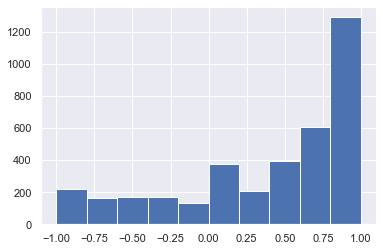

In [859]:
plt.hist(syntok_dom_topics['compound_sentiment'])

(array([ 788.,    0.,    0.,    0.,    0.,  351.,    0.,    0.,    0.,
        2585.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

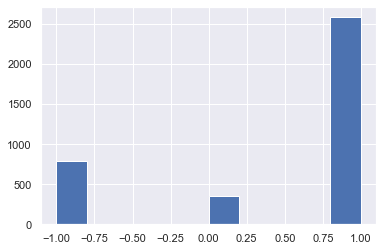

In [860]:
plt.hist(syntok_dom_topics['int_scores'])

In [861]:
syntok_plot_df_1 = syntok_dom_topics[syntok_dom_topics['num_tokens']>=5]
syntok_plot_df_2 = syntok_dom_topics[syntok_dom_topics['num_tokens']>=2]

In [863]:
review_numbers_5tokens = list(syntok_plot_df_1['review_number'].unique())
review_numbers_2tokens = list(syntok_plot_df_2['review_number'].unique())

final_score_dict_5tokens = score_reviews(review_numbers_5tokens,syntok_plot_df_1)
final_score_dict_2tokens = score_reviews(review_numbers_2tokens,syntok_plot_df_2)

In [864]:
print(final_score_dict_5tokens,'\n')
print(final_score_dict_2tokens,'\n')

{'Content & Authenticity': [0.836, 0.037, 0.127], 'Characters': [0.594, 0.085, 0.321], 'Strategic Gameplay': [0.588, 0.055, 0.358], 'Tactical Gameplay': [0.663, 0.071, 0.266], 'UX/UI, Performance, Stability': [0.679, 0.051, 0.27]} 

{'Content & Authenticity': [0.766, 0.1, 0.134], 'Characters': [0.495, 0.202, 0.303], 'Strategic Gameplay': [0.598, 0.075, 0.326], 'Tactical Gameplay': [0.655, 0.071, 0.274], 'UX/UI, Performance, Stability': [0.651, 0.081, 0.268]} 



In [865]:
syntok_score_df_1 = pd.DataFrame(final_score_dict_5tokens).T
#overall_score_df_1.index = ['Pos','Neutral','Neg']
syntok_score_df_1.columns = ['Pos','Neutral','Neg']
syntok_score_df_1

,Pos,Neutral,Neg
Content & Authenticity,0.836,0.037,0.127
Characters,0.594,0.085,0.321
Strategic Gameplay,0.588,0.055,0.358
Tactical Gameplay,0.663,0.071,0.266
"UX/UI, Performance, Stability",0.679,0.051,0.270


In [866]:
syntok_score_df_2 = pd.DataFrame(final_score_dict_2tokens).T
#overall_score_df_2.index = ['Pos','Neutral','Neg']
syntok_score_df_2.columns = ['Pos','Neutral','Neg']
syntok_score_df_2

,Pos,Neutral,Neg
Content & Authenticity,0.766,0.100,0.134
Characters,0.495,0.202,0.303
Strategic Gameplay,0.598,0.075,0.326
Tactical Gameplay,0.655,0.071,0.274
"UX/UI, Performance, Stability",0.651,0.081,0.268


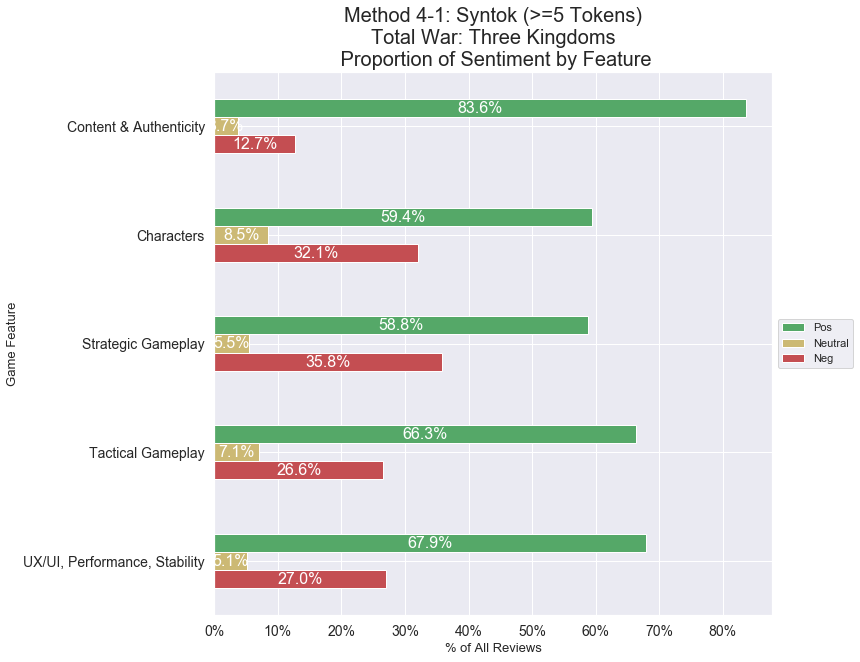

In [867]:
#plot visualisation, 4th attempt at aggregation

#WARNING: 5 tokens is the MEDIAN number of tokens! This visualisation is for only HALF of the usable data!

ax = syntok_score_df_1.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-1: Syntok (>=5 Tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

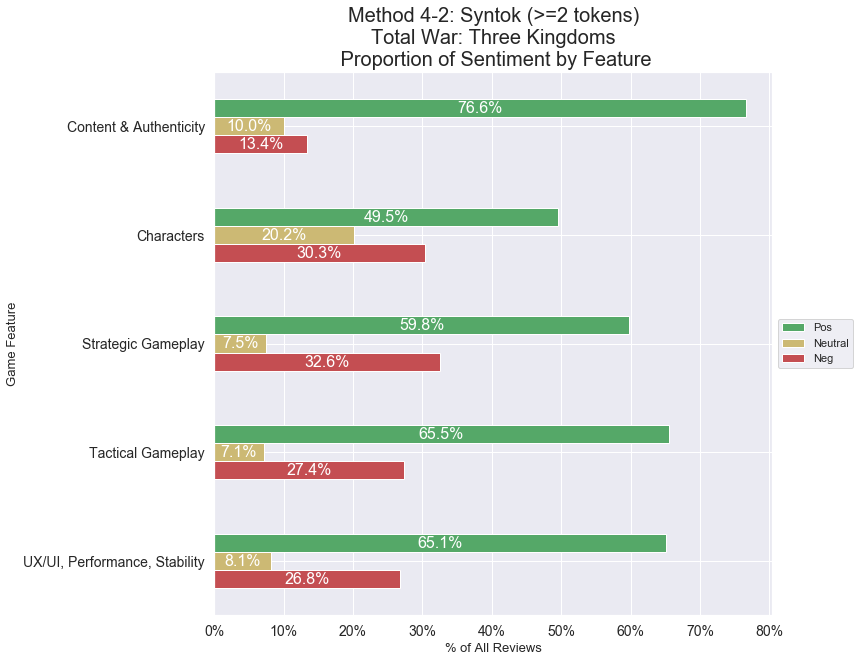

In [868]:
#plot visualisation, 4th attempt at aggregation
#75% of the data is intact (2 tokens is 25th Percentile)

ax = syntok_score_df_2.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

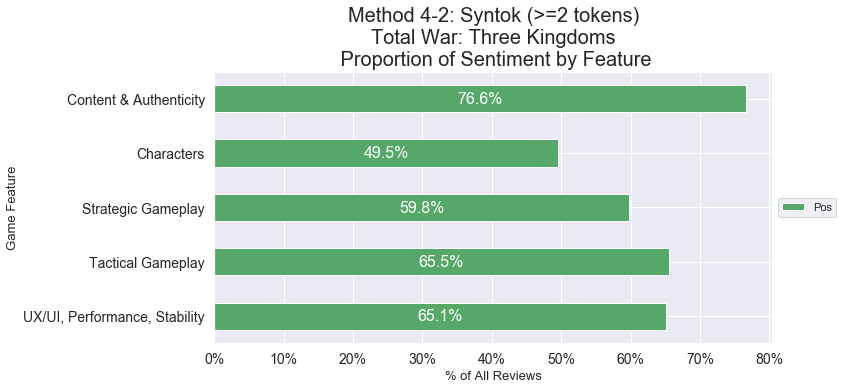

In [869]:
ax = syntok_score_df_2['Pos'].plot(kind='barh',figsize=(10,5),sort_columns=True,color=['g'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

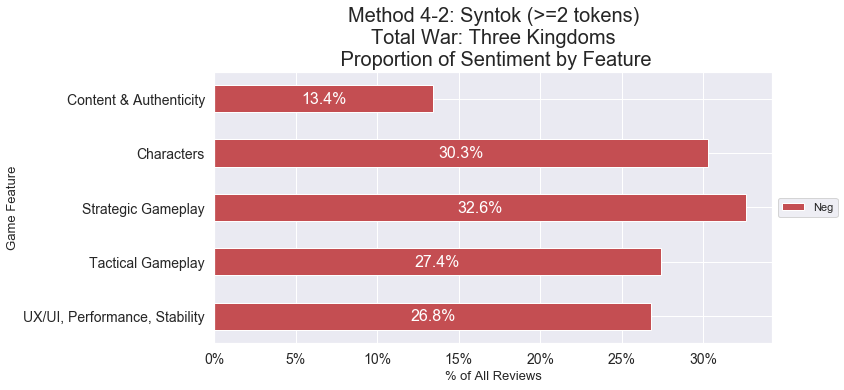

In [870]:
ax = syntok_score_df_2['Neg'].plot(kind='barh',figsize=(10,5),sort_columns=True,color=['r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

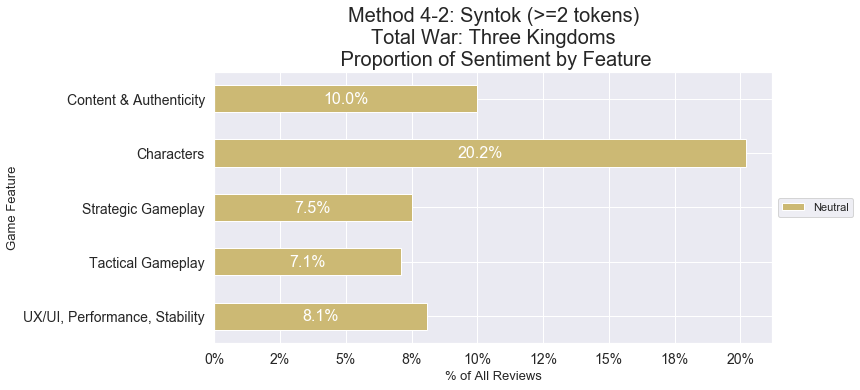

In [871]:
ax = syntok_score_df_2['Neutral'].plot(kind='barh',figsize=(10,5),sort_columns=True,color=['y'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nTotal War: Three Kingdoms\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

# Review: Method 4

Results with Syntok tokenisation look similar to Method 2 (by Review), but the results more reliable.

Method 4 results are much less likely to be due to random chance, due to the methodology.

I find this method to be a nice sweet spot that balances between bias and variance. 

Method ignores the context of sentences in their respective reviews and has flawed tokenisation.

Method 2 scores review sentiment on all the text but assigns the score to onl 1 topic out of several . 

Methods 1 and 3 both present risk of high misclassification rates because they go by extremely short sentences.

Method 4 results also more cleaerly indicate areas that need improvement while keeping neutral scores low.

I will go with the Method 4 (using 2 or more tokens).

In [872]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.7) & (syntok_dom_topics['compound_sentiment'] >0.7) & (syntok_dom_topics['num_tokens']>5)
most_pos_df = syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','compound_sentiment']]
most_pos_df.head()

,review_number,dominant_topic,original_text,compound_sentiment
0,2,Content & Authenticity,absolutely great game. all the new diplomacy o...,0.8519
1,7,Content & Authenticity,absolutely brilliant and beautiful game. worth...,0.9799
2,9,Content & Authenticity,great entry in the tw series ... while combat ...,0.8225
3,15,Content & Authenticity,"being newcomer to the total war franchise , ca...",0.7976
4,37,Tactical Gameplay,really like the design of this game. the gener...,0.9749


In [873]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.7) & (syntok_dom_topics['compound_sentiment'] <-0.5) & (syntok_dom_topics['num_tokens']>5)
syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','compound_sentiment']].head()

,review_number,dominant_topic,original_text,compound_sentiment
0,122,Content & Authenticity,the action is perhaps little more subtle than ...,-0.5789
1,135,Characters,""" i would rather betray the world than have th...",-0.8593
2,141,"UX/UI, Performance, Stability",really fun but one seriously bad issue is that...,-0.5128
3,154,"UX/UI, Performance, Stability",1/3 of the battles start will freeze the entir...,-0.6588
4,163,Content & Authenticity,"am loving every second of this title , and can...",-0.7370


In [874]:
#Currently, sentiment scores do not account for class balance, so the data is noisy
#weight the scores by the class balance
syntok_dom_topics['dominant_topic'].value_counts(normalize=True)

Content & Authenticity           0.561224
Tactical Gameplay                0.167562
Characters                       0.118421
UX/UI, Performance, Stability    0.082975
Strategic Gameplay               0.069817
Name: dominant_topic, dtype: float64

In [875]:
cls_weights = dict(syntok_dom_topics['dominant_topic'].value_counts(normalize=True))
cls_weights

{'Content & Authenticity': 0.5612244897959183,
 'Tactical Gameplay': 0.16756176154672395,
 'Characters': 0.11842105263157894,
 'UX/UI, Performance, Stability': 0.08297529538131042,
 'Strategic Gameplay': 0.06981740064446831}

In [876]:
for key, value in cls_weights.items():
    cls_weights[key] = 1-value    #give more weight to items that appear less in the class

cls_weights

{'Content & Authenticity': 0.4387755102040817,
 'Tactical Gameplay': 0.832438238453276,
 'Characters': 0.881578947368421,
 'UX/UI, Performance, Stability': 0.9170247046186896,
 'Strategic Gameplay': 0.9301825993555317}

In [877]:
wtd_score_lst = []

for i in range(len(syntok_dom_topics)):
    wtd_score = cls_weights[syntok_dom_topics['dominant_topic'][i]] * syntok_dom_topics['compound_sentiment'][i]
    
    wtd_score_lst.append(wtd_score)


syntok_dom_topics['weighted_compound_sentiment'] = wtd_score_lst
syntok_dom_topics.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores,weighted_compound_sentiment
0,0,Strategic Gameplay,0.6707,"[diplomacy, joke, military_access, cao_cao, wa...","[1, diplomacy, it, is, joke, nothing, works, y...",38,"faction, army, diplomacy, vassal, war, player,...",1. diplomacy it is joke. nothing works. you ha...,-0.9541,-1,-0.887487
1,0,Tactical Gameplay,0.7355,"[troop, chain, troop, building, kind, troop, a...","[2, troops, in, twh, also, in, rome, all, is, ...",26,"unit, battle, faction, army, general, characte...",2. troops. in twh ( also in rome ) all is simp...,-0.1280,-1,-0.106552
2,0,Tactical Gameplay,0.6831,"[city, building, ton, building, buff, task, bu...","[3, city, building, tons, of, buildings, that,...",21,"unit, battle, faction, army, general, characte...",3. city building. tons of buildings that you w...,-0.7448,-1,-0.620000
3,1,Characters,0.7433,"[lu_bu, lu_bu]","[pursued, lu, bu, now, am, lu, bu]",2,"china, war, cao_cao, lu_bu, liu_bei, yuan_shao...",pursued lu bu. now am lu bu.,0.0000,0,0.000000
4,2,Content & Authenticity,0.9391,"[diplomacy_options, depth, unit_variety, warha...","[absolutely, great, game, all, the, new, diplo...",11,"three_kingdoms, series, fan, diplomacy, battle...",absolutely great game. all the new diplomacy o...,0.8519,1,0.373793


In [878]:
#get most positive or negative sentences by dominant topic

def get_top_sents(contrib, compound, tokens,desired):

    top_sent_dict = {}
    
    for topic in topic_dict.values():

        
        topic_df = syntok_dom_topics[syntok_dom_topics['dominant_topic']==topic]
        
        if compound >0.1:
        
            sent_mask = (syntok_dom_topics['topic_perc_contrib'] >= contrib) & (syntok_dom_topics['compound_sentiment'] > compound) & (syntok_dom_topics['num_tokens'] >= tokens)

            top_sents = topic_df[sent_mask][['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
            
            top_sents = top_sents.sort_values(['compound_sentiment'],ascending = False)
            
            top_x_sents = list(top_sents['original_text'])[:desired]
            
            top_sent_dict[topic] = top_x_sents
            
        elif compound <-0.1:
            
            sent_mask = (syntok_dom_topics['topic_perc_contrib'] >= contrib) & (syntok_dom_topics['compound_sentiment'] < compound) & (syntok_dom_topics['num_tokens'] >= tokens)
            
            top_sents = topic_df[sent_mask][['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
            
            top_sents = top_sents.sort_values(['compound_sentiment'],ascending = True)
            
            top_x_sents = list(top_sents['original_text'])[:desired]
            
            top_sent_dict[topic] = top_x_sents
            
        else:
            
            sent_mask = (syntok_dom_topics['topic_perc_contrib'] >= contrib) & (-0.1 <= syntok_dom_topics['compound_sentiment'] <= 0.1) & (syntok_dom_topics['num_tokens'] >= tokens)
            
            top_sents = topic_df[sent_mask][['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
            
            top_sents = top_sents.sort_values(['compound_sentiment'],ascending = False)
            
            top_x_sents = list(top_sents['original_text'])[:desired] #neural sentiments
        
            top_sent_dict[topic] = top_x_sents
            
    
    return top_sent_dict

In [888]:
# Get 2 top reviews from each category (change the last integer to vary this)

top_pos_dict = get_top_sents(0.7,0.7,5,2)
for topic in topic_dict.values():
    print('***',topic,'***\n')
    for i in range(len(top_pos_dict[topic])):
        print('('+str(i+1)+')',top_pos_dict[topic][i],'\n')

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


*** Content & Authenticity ***

(1) so here is the thing , am not one to actively put reviews on games that am cracked out on , but this game is massive culmination of all the great things ca has put together over the years into game , and in an era that absolutely love. the entire three kingdoms era has always enthralled me since was young , yes it did start off with the dynasty warriors series , but it has excelled beyond that long time ago. this game alone has sufficed my love for building the cities , taking control of the areas , rts combat during round , hero duels watching sun jian or cao cao or lie bei beat the ever living crap out of someone is one of the greatest things to watch. this game feels like its an absolute mix of everything someone that enjoys what ca has made over the years. love this game , and the fact that ca did it so beautifully is an amazing feat of itself. the best part about this game is you can follow one of the warlords of the era , or create your own and

In [889]:
#get 2 top negative reviews from each category

top_neg_dict = get_top_sents(0.5,-0.5,3,2)
for topic in topic_dict.values():
    print('***',topic,'***\n')
    for i in range(len(top_neg_dict[topic])):
        print('('+str(i+1)+')',top_neg_dict[topic][i],'\n')

C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Alfred\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


*** Content & Authenticity ***

(1) oh oh oh ohhhhhhhh everybody was kung fu fighting , those cats were fast as lightning in fact it was little bit frightening , but they fought with expert timing there were funky china men from funky chinatown they were trapping bend up , they were trapping bend down it is an ancient chinese art , and everybody knew their part for my friend , am not you stiff , then am kickin ' from the hip everybody was kung fu fighting , those kids were fast as lightning in fact it was little bit frightening , but they fought with expert timing there was funky billy jim and little sammy john he said , here comes the big boss , let us get it on he took the bow and made stand , started swaying with the hand sudden motion made me stiff , now we are into brandnew trip everybody was kung fu fighting , those kids were fast as lightning in fact it was little bit frightening , but they did it with expert timing everybody was kung fu fighting , those kids were fast as lightn

# Final Roundup of SteamVox v0.1

Method 4 is able to produce output that can be used to discover which features of the game need to be reviewed for future updates.

The model has fulfilled the purpose it was built for.

### Model features
1. Scrapes reviews for your chosen game (Credit to https://github.com/woctezuma/download-steam-reviews! Thanks so much for all those discussions and upgrades.)
2. Cleans unhelpful reviews out of the dataset
3. Breaks usable reviews into paragraphs, then assigns topics (game features) and sentiment scores
4. Provides snapshot of player sentiment per game feature
5. Model identifies topics correctly ~85% of the time 


### More room for improvement

Obstacles eliminated:
1. Short spam reviews
2. Generic "this is the best game" reviews
3. Typos (filtered out based on frequency)
    - Heavily typoed reviews are relatively uncommon, but not rare (sssooome playersss liek typnggg lkie tissss)
4. Named entities not lost (e.g. characters) - n-grams were helpful
5. Reviews that are long but hold no meaningful tokens

Risks minimised, but still present:
1. Multiple languages
2. Spam/meme reviews that are very long
3. Misclassification
4. Incorrect sentiment score (related to sarcasm, below)

Obstacles that the current model cannot handle:
1. Sarcasm
2. Players using vulgarities to emphasise their love for the game (VADER tends to misread these as negatives)
3. Spam reviews that are long and in multiple languages (e.g. players spamming the names of political events as a form of online protest against the People's Republic of China)
4. Internet randomness
    - Sometimes, people will write incoherent reviews. 

Performance issues:
1. Lemmatisation is computationally more intensive and does not work well on large datasets.
    - Stemming will be considered for future optimisation.
    - Some notebooks (especially) this one can take several minutes to run.
    
2. Code may still be heavy to read. 
    - Many cells were converted into more efficient forms (e.g. converting into for loops, converting some of those into functions)
    - Will explore further optimisation

In [891]:
syntok_dom_topics.to_csv('./dataframes/syntok_dom_topics.csv')
syntok_score_df_2.to_csv('./dataframes/syntok_score_df_2.csv')
most_pos_df_2.to_csv('./dataframes/most_pos_df_2.csv')
most_neg_df_2.to_csv('./dataframes/most_neg_df_2.csv')

# References

https://medium.com/@makcedward/nlp-pipeline-sentence-tokenization-part-6-86ed55b185e6

https://github.com/nuwapi/DoctorSnapshot/

https://github.com/fnl/syntok/blob/master/README.rst